## 멀티모달 RAG
* 옵션 1:
    * 다중 모달 임베딩(예: CLIP)을 사용하여 이미지와 텍스트를 임베딩합니다.
    * 유사성 검색을 사용하여 둘 다 검색합니다.
    * 다중 모달 LLM에 원본 이미지와 텍스트 조각을 전달하여 답변을 합성합니다.

* 옵션 2:
    * 다중 모달 LLM(예: GPT-4V, GPT4o, LLaVA, FUYU-8b)을 사용하여 이미지에서 텍스트 요약을 생성합니다.
    * 텍스트를 임베딩하고 검색합니다.
    * LLM에 텍스트 조각을 전달하여 답변을 합성합니다.

* 옵션 3 (!!)
    * 다중 모달 LLM(예: GPT-4V, GPT4o, LLaVA, FUYU-8b)을 사용하여 이미지에서 텍스트 요약을 생성합니다.
    * 원본 이미지에 대한 참조와 함께 이미지 요약을 임베딩하고 검색합니다.
    * 다중 모달 LLM에 원본 이미지와 텍스트 조각을 전달하여 답변을 합성합니다.

![](./img/multimodal.png)

* 출처: https://github.com/teddylee777/langchain-kr/blob/main/12-RAG/10-Multi_modal_RAG-GPT-4o.ipynb

In [1]:
! pip install -U langchain openai chromadb langchain-experimental

  Using cached langchain_community-0.2.1-py3-none-any.whl.metadata (8.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.5/199.5 kB 2.0 MB/s eta 0:00:00a 0:00:01
Using cached langchain_community-0.2.1-py3-none-any.whl (2.1 MB)


In [2]:
! pip install "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib chromadb tiktoken
# ! brew install poppler
# ! brew install tesseract

  Using cached Markdown-3.6-py3-none-any.whl.metadata (7.0 kB)
  Using cached pytesseract-0.3.10-py3-none-any.whl.metadata (11 kB)
  Using cached xlrd-2.0.1-py2.py3-none-any.whl.metadata (3.4 kB)
  Using cached unstructured_inference-0.7.33-py3-none-any.whl.metadata (5.9 kB)
  Using cached unstructured.pytesseract-0.3.12-py3-none-any.whl.metadata (11 kB)
  Using cached python_docx-1.1.2-py3-none-any.whl.metadata (2.0 kB)
  Using cached openpyxl-3.1.2-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached pypandoc-1.13-py3-none-any.whl.metadata (16 kB)
  Using cached pdf2image-1.17.0-py3-none-any.whl.metadata (6.2 kB)
  Using cached python_pptx-0.6.23-py3-none-any.whl.metadata (18 kB)
  Using cached msg_parser-1.2.0-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached google_cloud_vision-3.7.2-py2.py3-none-any.whl.metadata (5.2 kB)
  Using cached effdet-0.4.1-py3-none-any.whl.metadata (33 kB)
  Using cached layoutparser-0.3.4-py3-none-any.whl.metadata (7.7 kB)
  Using cached opencv_pyth

In [7]:
fpath = "./data/"
fname = "2024-05-28.pdf"

In [8]:
import os
from langchain_text_splitters import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf

def extract_pdf_elements(path, fname):
    """
    PDF 파일에서 이미지, 테이블, 그리고 텍스트 조각을 추출합니다.
    path: 이미지(.jpg)를 저장할 파일 경로
    fname: 파일 이름
    """
    return partition_pdf(
        filename=os.path.join(path, fname),
        extract_images_in_pdf=True,  # PDF 내 이미지 추출 활성화
        infer_table_structure=True,  # 테이블 구조 추론 활성화
        chunking_strategy="by_title",  # 제목별로 텍스트 조각화
        max_characters=4000,  # 최대 문자 수
        new_after_n_chars=3800,  # 이 문자 수 이후에 새로운 조각 생성
        combine_text_under_n_chars=2000,  # 이 문자 수 이하의 텍스트는 결합
        image_output_dir_path=path,  # 이미지 출력 디렉토리 경로
    )

def categorize_elements(raw_pdf_elements):
    """
    PDF에서 추출된 요소를 테이블과 텍스트로 분류합니다.
    raw_pdf_elements: unstructured.documents.elements의 리스트
    """
    tables = []  # 테이블 저장 리스트
    texts = []  # 텍스트 저장 리스트
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))  # 테이블 요소 추가
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))  # 텍스트 요소 추가
    return texts, tables


# 요소 추출
raw_pdf_elements = extract_pdf_elements(fpath, fname)

# 텍스트, 테이블 추출
texts, tables = categorize_elements(raw_pdf_elements)

# 선택사항: 텍스트에 대해 특정 토큰 크기 적용
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=4000, chunk_overlap=0  # 텍스트를 4000 토큰 크기로 분할, 중복 없음
)
joined_texts = " ".join(texts)  # 텍스트 결합
texts_4k_token = text_splitter.split_text(joined_texts)  # 분할 실행

unpack requires a buffer of 46 bytes
PDF text extraction failed, skip text extraction...


In [13]:
len(texts_4k_token)

5

In [14]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    텍스트 요소 요약
    texts: 문자열 리스트
    tables: 문자열 리스트
    summarize_texts: 텍스트 요약 여부를 결정. True/False
    """

    # 프롬프트 설정
    prompt_text = """You are an assistant tasked with summarizing tables and text in Korean for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # 텍스트 요약 체인
    model = ChatOpenAI(temperature=0, model="gpt-4o")
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # 요약을 위한 빈 리스트 초기화
    text_summaries = []
    table_summaries = []

    # 제공된 텍스트에 대해 요약이 요청되었을 경우 적용
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    # 제공된 테이블에 적용
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries

text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=True
)

In [23]:
# 이미지 요약
import base64
import os

from langchain_core.messages import HumanMessage

def encode_image(image_path):
    # 이미지 파일을 base64 문자열로 인코딩합니다.
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")
    
def image_summarize(img_base64, prompt):
    # 이미지 요약을 생성합니다.
    chat = ChatOpenAI(model="gpt-4o", max_tokens=2048)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content

def generate_img_summaries(path):
    """
    이미지에 대한 요약과 base64 인코딩된 문자열을 생성합니다.
    path: Unstructured에 의해 추출된 .jpg 파일 목록의 경로
    """

    # base64로 인코딩된 이미지를 저장할 리스트
    img_base64_list = []

    # 이미지 요약을 저장할 리스트
    image_summaries = []

    # 요약을 위한 프롬프트
    prompt = """You are an assistant tasked with summarizing images in Korean for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # 이미지에 적용
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries

img_base64_list, image_summaries = generate_img_summaries("./figures")

In [28]:
len(image_summaries)

27

In [29]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    요약을 색인화하지만 원본 이미지나 텍스트를 반환하는 검색기를 생성합니다.
    """

    # 저장 계층 초기화
    store = InMemoryStore()
    id_key = "doc_id"

    # 멀티 벡터 검색기 생성
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # 문서를 벡터 저장소와 문서 저장소에 추가하는 헬퍼 함수
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [
            str(uuid.uuid4()) for _ in doc_contents
        ]  # 문서 내용마다 고유 ID 생성
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(
            summary_docs
        )  # 요약 문서를 벡터 저장소에 추가
        retriever.docstore.mset(
            list(zip(doc_ids, doc_contents))
        )  # 문서 내용을 문서 저장소에 추가

    # 텍스트, 테이블, 이미지 추가
    if text_summaries:
        add_documents(retriever, text_summaries, texts)

    if table_summaries:
        add_documents(retriever, table_summaries, tables)

    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever

In [30]:
vectorstore = Chroma(
    collection_name="sample-rag-multi-modal", embedding_function=OpenAIEmbeddings()
)

# 검색기 생성
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

In [32]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    """base64 인코딩된 문자열을 이미지로 표시"""
    # base64 문자열을 소스로 사용하는 HTML img 태그 생성
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # HTML을 렌더링하여 이미지 표시
    display(HTML(image_html))


def looks_like_base64(sb):
    """문자열이 base64로 보이는지 확인"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    base64 데이터가 이미지인지 시작 부분을 보고 확인
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # 처음 8바이트를 디코드하여 가져옴
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Base64 문자열로 인코딩된 이미지의 크기 조정
    """
    # Base64 문자열 디코드
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # 이미지 크기 조정
    resized_img = img.resize(size, Image.LANCZOS)

    # 조정된 이미지를 바이트 버퍼에 저장
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # 조정된 이미지를 Base64로 인코딩
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    base64로 인코딩된 이미지와 텍스트 분리
    """
    b64_images = []
    texts = []
    for doc in docs:
        # 문서가 Document 타입인 경우 page_content 추출
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    컨텍스트를 단일 문자열로 결합
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # 이미지가 있으면 메시지에 추가
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # 분석을 위한 텍스트 추가
    text_message = {
        "type": "text",
        "text": (
            "You are financial analyst tasking with providing investment advice.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide investment advice related to the user question. Answer in Korean. Do NOT translate company names.\n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    멀티모달 RAG 체인
    """

    # 멀티모달 LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", max_tokens=2048)

    # RAG 파이프라인
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# RAG 체인 생성
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

In [71]:
query = "SK하이닉스 몸값이 오르는 이유에 대해 알려줘"
docs = retriever_multi_vector_img.invoke(query, limit=6)

len(docs)

4


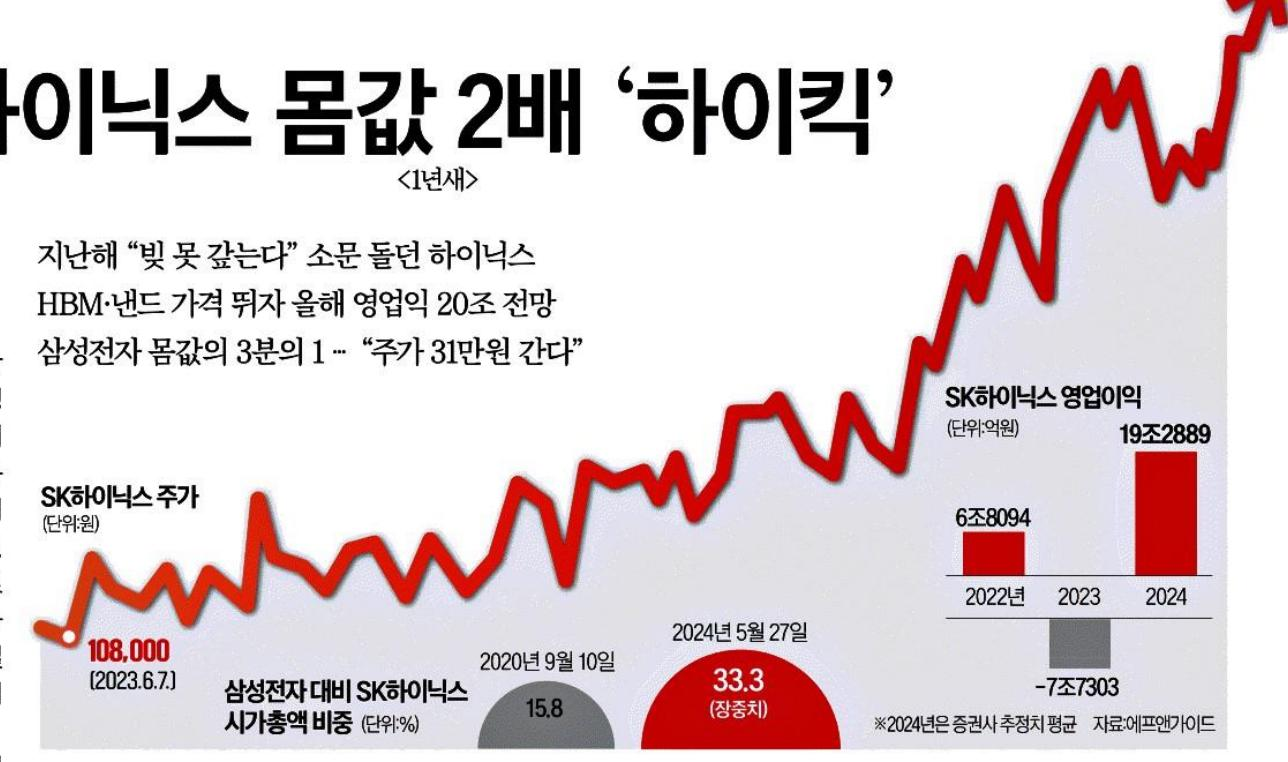

In [72]:
plt_img_base64(docs[0])


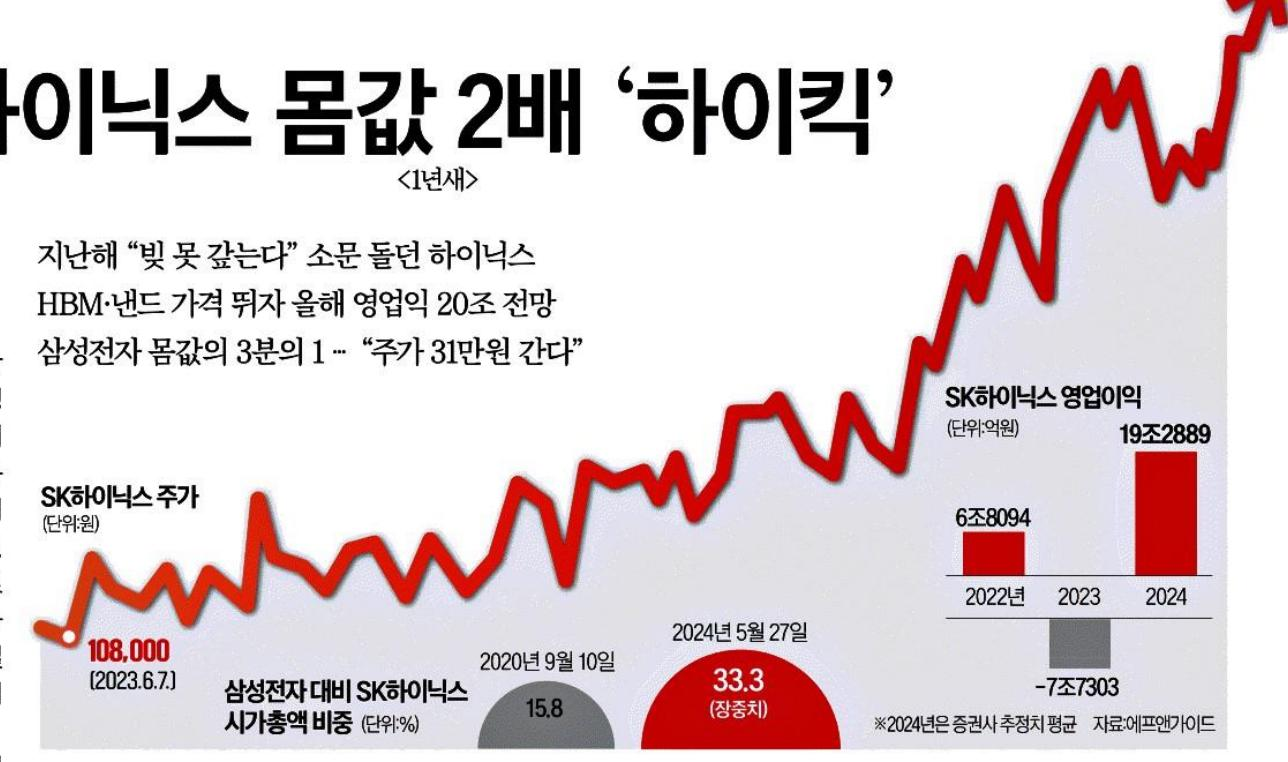

In [68]:
plt_img_base64(img_base64_list[25])

In [73]:
image_summaries[25]

'SK하이닉스 주가와 영업이익 그래프, 2022-2024 전망, HBM·낸드 가격 상승, 삼성전자 대비 SK하이닉스 시가총액 비중 포함'

In [74]:
print(chain_multimodal_rag.invoke(query))

SK하이닉스의 몸값이 오르는 이유는 여러 가지 요인에 기인합니다. 아래는 주요 요인들입니다:

1. **HBM 및 랜드 가격 상승**: HBM(High Bandwidth Memory)과 랜드(NAND) 가격이 상승하면서 SK하이닉스의 수익성이 개선되고 있습니다. 이는 반도체 시장의 수요 증가와 공급 부족으로 인한 가격 상승이 주요 원인입니다.

2. **영업이익 전망**: 2024년 SK하이닉스의 영업이익이 19조 2889억 원으로 예상되고 있습니다. 이는 2022년의 6조 8094억 원에 비해 크게 증가한 수치로, 회사의 재무 상태가 크게 개선될 것으로 보입니다.

3. **주가 상승**: SK하이닉스의 주가는 2023년 6월 7일 기준으로 108,000원에서 2024년 5월 27일 기준으로 크게 상승할 것으로 예상됩니다. 이는 투자자들의 기대감이 반영된 결과입니다.

4. **삼성전자 대비 시가총액 비중 증가**: SK하이닉스의 시가총액 비중이 삼성전자 대비 증가하고 있습니다. 이는 SK하이닉스의 시장 점유율이 높아지고 있음을 의미합니다.

5. **기술력 및 시장 전략**: SK하이닉스는 일본 시장 공략을 위한 트랙레코드(수주 이력)를 쌓고 있으며, 해상 풍력 발전 등 새로운 시장 진출을 통해 성장 가능성을 높이고 있습니다.

이러한 요인들로 인해 SK하이닉스의 몸값이 오르고 있으며, 앞으로도 긍정적인 전망이 예상됩니다. 투자자들은 이러한 정보를 바탕으로 투자 결정을 내릴 수 있습니다.
